<a href="https://colab.research.google.com/github/giovannimmiranda/DL_20-06_GMM/blob/main/DL_20_06_Miranda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Exam - 20/06/2024**


Giovanni Michele Miranda,  507567

In [1]:
import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "https://github.com/giovannimmiranda/DL_20-06_GMM/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"
#Then use the following lines to read it:
import pickle as pk
with open(data_path, 'rb') as f:
  data = pk.load(f)
images = data['imgs']
y = data['labels']
labels = y[:,0]
bboxes = y[:,1:]

In [2]:
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

In [ ]:
batch_size = 5
bboxes[:batch_size]

array([[ 23,  42, 206, 199],
       [ 13,  70, 219, 160],
       [  8,  42, 221, 200],
       [ 22,  67, 218, 158],
       [ 15,  56, 212, 156]])

In [ ]:
images = (images - np.min(images)) / (np.max(images) - np.min(images))

In [ ]:
# Example labels to remove images from
label_to_remove_c1 = 1  # First class
label_to_remove_c2 = 2  # Second class

# Ensure there are enough images in the dataset
if labels.shape[0] > 184 and images.shape[0] > 184:
    # Find indices of images with the specified labels
    indices_to_remove_c1 = np.where(labels == label_to_remove_c1)[0]
    indices_to_remove_c2 = np.where(labels == label_to_remove_c2)[0]

    # Check if there are enough images to remove

    # Randomly select two indices from the first class
    random_indices_c1 = random.sample(list(indices_to_remove_c1), 2)
    # Randomly select one index from the second class
    random_indices_c2 = random.sample(list(indices_to_remove_c2), 1)

    # Remove the selected images and their corresponding labels
    images = np.delete(images, random_indices_c1, axis=0)
    labels = np.delete(labels, random_indices_c1, axis=0)
    # Adjust the second class index due to the removal of the first class indices
    random_indices_c2 = [i - np.sum(random_indices_c1 < i) for i in random_indices_c2]
    images = np.delete(images, random_indices_c2, axis=0)
    labels = np.delete(labels, random_indices_c2, axis=0)

    print(f"Removed images at indices: {random_indices_c1} from class 1 and {random_indices_c2} from class 2")
    print(f"New dataset size: {images.shape[0]} images, {labels.shape[0]} labels")
else:
    print(f"The dataset is already set! It has {images.shape[0]} images.")
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("\nNow the dataset is balanced:")
    for label, count in zip(unique_labels, counts):
      print(f"\n Class {label}: {count} images")

Removed images at indices: [6, 5] from class 1 and [66] from class 2
New dataset size: 183 images, 183 labels


In [ ]:
images.shape

(183, 227, 227, 3)

In [ ]:
image_width_height = 227

# Example: Normalize bounding boxes (assuming `bboxes` is an array of shape (num_images, 4))
bboxes_normalized = bboxes.astype(float)
bboxes_normalized[:, 0] /= image_width_height  # Normalize x1
bboxes_normalized[:, 1] /= image_width_height  # Normalize y1
bboxes_normalized[:, 2] /= image_width_height  # Normalize x2
bboxes_normalized[:, 3] /= image_width_height  # Normalize y2

print(f"Printing first {batch_size} normalized bounding boxes:")
print(bboxes_normalized[:batch_size])

# Example: Removing images at indices [47, 36] from class 1 and [115] from class 2
removed_indices = [47, 36, 115]

# Remove corresponding bounding boxes
bboxes_normalized = np.delete(bboxes_normalized, removed_indices, axis=0)

# Now `bboxes_normalized` contains the updated bounding box data after removal
print("Updated number of bounding boxes:", len(bboxes_normalized))
print(bboxes_normalized.shape)

Printing first 5 normalized bounding boxes:
[[0.10132159 0.18502203 0.90748899 0.87665198]
 [0.05726872 0.30837004 0.96475771 0.70484581]
 [0.03524229 0.18502203 0.97356828 0.88105727]
 [0.0969163  0.29515419 0.96035242 0.69603524]
 [0.0660793  0.24669604 0.9339207  0.68722467]]
Updated number of bounding boxes: 183
(183, 4)


In [ ]:
X_train, X_val, y_train_cls, y_val_cls, y_train_bbox, y_val_bbox = train_test_split(images, labels, bboxes_normalized, test_size=0.2, random_state=42)

In [ ]:
#X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

y_train_cls = y_train_cls - 1
y_val_cls = y_val_cls - 1

# Create a TensorFlow dataset
seed = random.randint(0, 1000)

num_classes = 3
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_cls))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_cls))

# Shuffle and batch the datasets
batch_size = 16
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Define a Residual Block with L2 regularization
def residual_block(x, filters, kernel_size=3, stride=1, l2_reg=0.001):  # Add L2 regularization parameter
    shortcut = x

    initializer = tf.keras.initializers.HeUniform(seed=seed)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Add shortcut (identity mapping)
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                                          kernel_initializer=initializer)(shortcut)
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

# Define the model with residual blocks and L2 regularization
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
inputs = tf.keras.Input(shape=input_shape)
x = residual_block(inputs, 32, l2_reg=0.001)  # Apply L2 regularization to residual blocks
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64, l2_reg=0.001)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 128, l2_reg=0.001)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 256, l2_reg=0.001)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001),
                          kernel_initializer=tf.keras.initializers.HeUniform(seed=seed))(x)  # L2 on Dense layer


# Classification branch
outputs_cls = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_output')(x)

# Regression branch
outputs_reg = tf.keras.layers.Dense(4, activation='linear', name='regression_output')(x)  # Assuming 4 for bounding box (x, y, w, h)

# Define the model with multiple outputs
model = tf.keras.Model(inputs=inputs, outputs=[outputs_cls, outputs_reg])

# Compile the model with separate loss functions for each output
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)  # Add gradient clipping

model.compile(optimizer=optimizer,
              loss={'classification_output': 'sparse_categorical_crossentropy', 'regression_output': 'mean_squared_error'},
              metrics={'classification_output': 'accuracy', 'regression_output': 'mse'})


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, mode='min', restore_best_weights=True)


# Train the model with combined data
history = model.fit(X_train, {'classification_output': y_train_cls, 'regression_output': y_train_bbox},
                    epochs=20, batch_size=batch_size, validation_data=(X_val, {'classification_output': y_val_cls, 'regression_output': y_val_bbox}))

# Evaluate the model
losses = model.evaluate(X_val, {'classification_output': y_val_cls, 'regression_output': y_val_bbox})
#print("Total Loss:", losses[0]) # Access the total loss
print("Classification Loss:", losses[1]) # Access the classification loss
print("Regression Loss:", losses[2]) # Access the regression loss

########################################################################

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - class_output_accuracy: 0.0000e+00 - loss: nan - regression_output_mse: nan - val_class_output_accuracy: 0.0000e+00 - val_loss: nan - val_regression_output_mse: nan
Epoch 2/20


KeyboardInterrupt: 

In [ ]:
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)  # Add gradient clipping
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, mode='min', restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[early_stopping])

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_dataset)
print("Validation loss: {:.4f}".format(val_loss))
print("Validation accuracy: {:.4f}".format(val_acc))

In [ ]:
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001),
                          kernel_initializer=tf.keras.initializers.HeUniform(seed=seed))(x)  # L2 on Dense layer
# Classification branch
outputs_cls = tf.keras.layers.Dense(num_classes, activation='softmax', name='class_output')(x)

# Regression branch
outputs_reg = tf.keras.layers.Dense(4, activation='linear', name='regression_output')(x)  # Assuming 4 for bounding box (x, y, w, h)

# Define the model with multiple outputs
model = tf.keras.Model(inputs=inputs, outputs=[outputs_cls, outputs_reg])

# Compile the model with separate loss functions for each output
model.compile(optimizer='adam',
              loss={'class_output': 'sparse_categorical_crossentropy', 'regression_output': 'mean_squared_error'},
              metrics={'class_output': 'accuracy', 'regression_output': 'mse'})

# Train the model with combined data
history = model.fit(X_train, {'class_output': y_train_cls, 'regression_output': y_train_reg},
                    epochs=10, batch_size=32, validation_data=(X_val, {'class_output': y_val_cls, 'regression_output': y_val_reg}))

# Evaluate the model
losses = model.evaluate(X_val, {'class_output': y_val_cls, 'regression_output': y_val_reg})
print("Classification Loss:", losses['class_output'])
print("Regression Loss:", losses['regression_output'])

# Predictions
predictions = model.predict(X_val[:10])
class_predictions = predictions['class_output']
regression_predictions = predictions['regression_output']

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


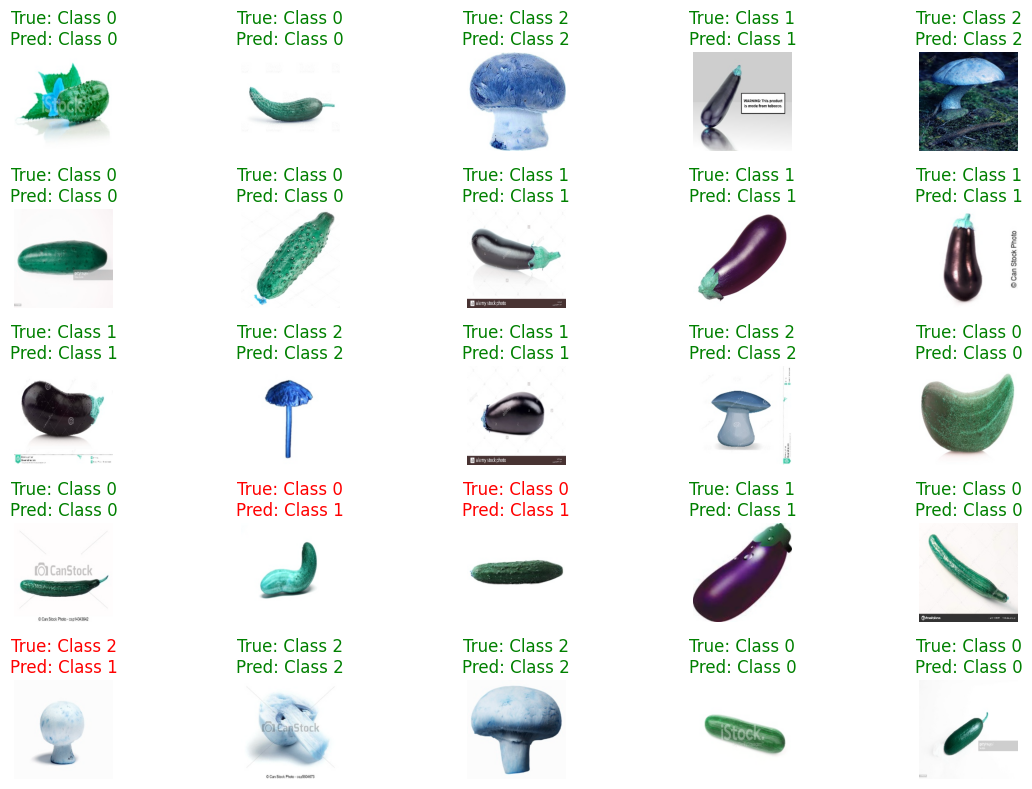

In [ ]:
# Function to plot images with their predicted and true labels
def plot_images_with_labels(images, true_labels, pred_labels, class_names):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f'True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}', color='green' if true_labels[i] == pred_labels[i] else 'red')
    plt.tight_layout()
    plt.show()

# Assuming X_val contains your validation images and y_val_cls contains corresponding true class labels

# Get predicted class labels (assuming softmax output, take argmax)
predicted_labels = np.argmax(model.predict(X_val), axis=1)

# List of class names (replace with your actual class names)
class_names = ['Class 0', 'Class 1', 'Class 2']  # Replace with your actual class names

# Visualize a sample of validation images with their predicted and true labels
sample_images = X_val[:25]  # Adjust number of images to plot
sample_true_labels = y_val[:25]  # True labels from validation set
sample_pred_labels = predicted_labels[:25]  # Predicted labels from model

plot_images_with_labels(sample_images, sample_true_labels, sample_pred_labels, class_names)